# train eda

In [16]:
%load_ext lab_black

In [63]:
from pyspark.sql import SparkSession, functions as F
from pathlib import Path

root = Path("../data/intermediate")

spark = (
    SparkSession.builder.config("spark.driver.memory", "24g")
    .config("spark.local.dir", "../data/tmp/spark")
    .getOrCreate()
)
train_data = spark.read.parquet((root / "train_data").as_posix())
print("train data", train_data.count())
train_labels = spark.read.parquet((root / "train_labels").as_posix())
print("train labels", train_labels.count())

train data 5531451
train labels 458913


In [64]:
train_labels.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- target: string (nullable = true)



In [65]:
train_data.show(n=1, vertical=True)

-RECORD 0---------------------------
 customer_ID | 01701321f734a83cf... 
 S_2         | 2018-03-09           
 P_2         | 0.7991141189246276   
 D_39        | 0.0018977756851588   
 B_1         | 0.0149294309228475   
 B_2         | 1.0041355490422452   
 R_1         | 0.0016506345418425   
 S_3         | 0.023690307800842    
 D_41        | 0.0056964224058104   
 B_3         | 0.0037851765229165   
 D_42        | null                 
 D_43        | null                 
 D_44        | 0.0038395077274833   
 B_4         | 0.1104571844823881   
 D_45        | 0.5963165891091312   
 B_5         | 0.3650039952884494   
 R_2         | 0.0010843643516612   
 D_46        | 0.3863574341643171   
 D_47        | 0.5461895934810272   
 D_48        | 0.1747255267058227   
 D_49        | null                 
 B_6         | 0.1333546183277581   
 B_7         | 0.0442862927256806   
 B_8         | 0.0014701260897636   
 D_50        | null                 
 D_51        | 1.3364946781326723   
 

In [66]:
# how many entries are there per customer?
train_data.select("customer_ID", "S_2").groupby("customer_ID").count().orderBy(
    F.desc("count")
).show(n=10)

+--------------------+-----+
|         customer_ID|count|
+--------------------+-----+
|245bb7e56c51703ea...|   13|
|3f7a33eb0f763fb83...|   13|
|0716c4e22508c971d...|   13|
|2d5e876f8707f8b75...|   13|
|0c60d95b7b5d04b1e...|   13|
|2cc74b1f831e6c3b6...|   13|
|0c75383dfa80b0971...|   13|
|3032485111d1052df...|   13|
|18eb0a101c6cf6a67...|   13|
|309bec488432756f2...|   13|
+--------------------+-----+
only showing top 10 rows



In [67]:
(
    train_data.select("customer_ID", "S_2")
    .groupby("customer_ID")
    .count()
    .withColumn("customer_count", F.col("count"))
    .groupBy("customer_count")
    .count()
    .orderBy("customer_count")
).show()

+--------------+------+
|customer_count| count|
+--------------+------+
|             1|  5120|
|             2|  6098|
|             3|  5778|
|             4|  4673|
|             5|  4671|
|             6|  5515|
|             7|  5198|
|             8|  6110|
|             9|  6411|
|            10|  6721|
|            11|  5961|
|            12| 10623|
|            13|386034|
+--------------+------+



In [68]:
df = (
    train_data.groupby("customer_ID")
    .agg(F.min("S_2").alias("min_date"), F.max("S_2").alias("max_date"))
    .withColumn("date_range", F.datediff("max_date", "min_date"))
    .groupBy("date_range")
    .count()
    .orderBy("date_range")
).toPandas()
df

,date_range,count
0,0,5120
1,1,16
2,2,29
3,3,57
4,4,56
...,...,...
391,391,1546
392,392,1244
393,393,880
394,394,602


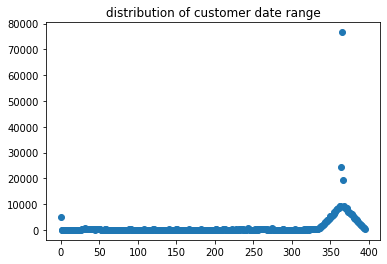

In [69]:
import matplotlib.pyplot as plt

plt.title("distribution of customer date range")
plt.scatter(df.date_range, df["count"])
plt.show()

In [78]:
categorical = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68",
]

for col in categorical:
    res = train_data.groupby(col).count().orderBy(F.desc("count"))
    res.printSchema()
    res.show()

root
 |-- B_30: string (nullable = true)
 |-- count: long (nullable = false)

+----+-------+
|B_30|  count|
+----+-------+
| 0.0|4710663|
| 1.0| 763955|
| 2.0|  54817|
|null|   2016|
+----+-------+

root
 |-- B_38: string (nullable = true)
 |-- count: long (nullable = false)

+----+-------+
|B_38|  count|
+----+-------+
| 2.0|1953232|
| 3.0|1255315|
| 1.0|1160047|
| 5.0| 444856|
| 4.0| 294917|
| 7.0| 259028|
| 6.0| 162040|
|null|   2016|
+----+-------+

root
 |-- D_114: string (nullable = true)
 |-- count: long (nullable = false)

+-----+-------+
|D_114|  count|
+-----+-------+
|  1.0|3316478|
|  0.0|2038257|
| null| 176716|
+-----+-------+

root
 |-- D_116: string (nullable = true)
 |-- count: long (nullable = false)

+-----+-------+
|D_116|  count|
+-----+-------+
|  0.0|5348109|
| null| 176716|
|  1.0|   6626|
+-----+-------+

root
 |-- D_117: string (nullable = true)
 |-- count: long (nullable = false)

+-----+-------+
|D_117|  count|
+-----+-------+
| -1.0|1456084|
|  3.0|1166400|

## preparing data for training

In [71]:
from pyspark.sql import Window

window = Window.partitionBy("customer_ID").orderBy(F.desc("S_2"))

min_age = (
    train_data.groupby("customer_ID")
    .agg(
        F.min("S_2").alias("min_date"),
        F.max("S_2").alias("max_date"),
        F.count("*").alias("n_statements"),
    )
    .withColumn("age", F.datediff("max_date", "min_date"))
    .select("customer_ID", "age", "n_statements")
)

prepared_df = (
    train_data.withColumn(
        "rank",
        F.row_number().over(window),
    )
    .where("rank = 1")
    .drop("rank")
    .join(min_age, on="customer_ID")
    .join(train_labels, on="customer_ID")
).cache()

prepared_df.count()
prepared_df.show(n=1, vertical=True)

-RECORD 0----------------------------
 customer_ID  | 0012e41fe6caa3ba3... 
 S_2          | 2018-03-17           
 P_2          | 0.6277000164214247   
 D_39         | 0.0056059437299577   
 B_1          | 0.0078683994017706   
 B_2          | 0.8100137006688944   
 R_1          | 0.0023951004697499   
 S_3          | null                 
 D_41         | 0.0073143976496239   
 B_3          | 0.0082780536191227   
 D_42         | 0.018026646256375    
 D_43         | null                 
 D_44         | 0.0033505789435878   
 B_4          | 0.0055205074277178   
 D_45         | 0.0296194439084377   
 B_5          | 0.007657400343818    
 R_2          | 0.0073921017936471   
 D_46         | 0.4289550674308784   
 D_47         | 0.0923194957015302   
 D_48         | 0.2357485272896307   
 D_49         | null                 
 B_6          | 0.0335547125370477   
 B_7          | 0.0079531255348116   
 B_8          | 1.0083370718082991   
 D_50         | null                 
 D_51       

In [62]:
prepared_df.groupby("age").count().limit(10).show()

+---+-----+
|age|count|
+---+-----+
|148|  120|
|392| 1244|
|243|  649|
| 31|  684|
|251|  171|
|137|  153|
| 85|  102|
| 65|  135|
| 53|  172|
|296|  177|
+---+-----+



In [60]:
from pyspark.ml.feature import VectorAssembler, Imputer

feature_columns = [c for c in prepared_df.columns[2:-1] if c not in categorical]
imputer = Imputer(inputCols=feature_columns, outputCols=feature_columns)

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

casted_df = prepared_df.select(
    "customer_ID", "target", *[F.col(c).cast("float").alias(c) for c in feature_columns]
)
imputed_df = imputer.fit(casted_df).transform(casted_df)
assembler.transform(imputed_df).head().features

DenseVector([0.6277, 0.0056, 0.0079, 0.81, 0.0024, 0.2291, 0.0073, 0.0083, 0.018, 0.1638, 0.0034, 0.0055, 0.0296, 0.0077, 0.0074, 0.429, 0.0923, 0.2357, 0.1911, 0.0336, 0.008, 1.0083, 0.176, 0.0002, 0.0015, 0.0034, 0.0819, 0.7017, 0.2388, 0.1148, 0.0061, 0.0072, 1.0095, 1.0094, 0.0004, 0.2222, 0.0089, 0.0051, 0.1795, 0.0433, 0.0016, 0.0056, 0.0035, 0.0444, 0.0043, 0.4886, 1.0066, 0.2279, 0.0069, 0.2896, 0.1883, 0.0029, 0.0088, 0.7252, 1.0044, 0.008, 0.0047, 0.1872, 0.0097, 0.001, 0.0016, 0.0012, 0.0061, 0.005, 0.0153, 0.0081, 0.5008, 0.0075, 0.1709, 0.956, 0.0072, 0.0013, 0.143, 0.0093, 0.003, 0.2602, 0.0066, 0.0032, 0.0039, 0.0097, 0.0096, 0.2528, 0.0074, 0.0064, 0.0072, 0.0064, 0.0092, 0.0023, 0.4684, 0.0005, 1.0041, 0.0097, 0.0089, 0.0065, 0.0001, 0.0054, 0.0032, 0.0018, 0.046, 0.0091, 0.0064, 1.0, 0.0034, 0.004, 0.2083, 1.0, 0.0089, 0.0089, 0.0081, 0.0036, 0.0049, 0.0036, 1.0098, 0.009, 0.009, 0.0072, 0.0093, 0.0032, 0.0005, 0.0026, 0.0003, 0.0022, 0.0075, 0.3121, 0.1397, 0.1375, 0

In [73]:
prepared_df.select(categorical).printSchema()

root
 |-- B_30: string (nullable = true)
 |-- B_38: string (nullable = true)
 |-- D_114: string (nullable = true)
 |-- D_116: string (nullable = true)
 |-- D_117: string (nullable = true)
 |-- D_120: string (nullable = true)
 |-- D_126: string (nullable = true)
 |-- D_63: string (nullable = true)
 |-- D_64: string (nullable = true)
 |-- D_66: string (nullable = true)
 |-- D_68: string (nullable = true)



In [81]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringified = [f"{c}_str" for c in categorical]
one_hot_cols = [f"{c}_ohe" for c in categorical]
string_indexer = StringIndexer(
    inputCols=categorical, outputCols=stringified, handleInvalid="keep"
)
ohe = OneHotEncoder(inputCols=stringified, outputCols=one_hot_cols)
res = string_indexer.fit(prepared_df).transform(prepared_df.select(categorical))
ohe.fit(res).transform(res)

DataFrame[B_30: string, B_38: string, D_114: string, D_116: string, D_117: string, D_120: string, D_126: string, D_63: string, D_64: string, D_66: string, D_68: string, B_30_str: double, B_38_str: double, D_114_str: double, D_116_str: double, D_117_str: double, D_120_str: double, D_126_str: double, D_63_str: double, D_64_str: double, D_66_str: double, D_68_str: double, B_30_ohe: vector, B_38_ohe: vector, D_114_ohe: vector, D_116_ohe: vector, D_117_ohe: vector, D_120_ohe: vector, D_126_ohe: vector, D_63_ohe: vector, D_64_ohe: vector, D_66_ohe: vector, D_68_ohe: vector]

This notebook is enough for me to start development on the actual transformations. I am going to pre-process this into a new dataset, which will include stratified sampling (for train/test split) and a bit more feature engineering on the categorical fields.